In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101, ResNet50, ResNet152, InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

import os
import time
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile

2024-05-18 01:23:13.913091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 01:23:13.913137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 01:23:13.914585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = '/kaggle/input/stage-2-classification/Stage 2 Classification'

In [3]:
temp_dir = tempfile.mkdtemp()

class_names = os.listdir(dataset_path)

os.makedirs(temp_dir + '/train')
os.makedirs(temp_dir + '/val')
os.makedirs(temp_dir + '/test')

for class_name in class_names:
    os.makedirs(temp_dir + '/train/' + class_name)
    os.makedirs(temp_dir + '/val/' + class_name)
    os.makedirs(temp_dir + '/test/' + class_name)
    
    image_names = os.listdir(dataset_path + '/' + class_name)
    np.random.shuffle(image_names)
    
    train_names = image_names[:int(len(image_names)*0.8)]
    val_names = image_names[int(len(image_names)*0.8):int(len(image_names)*0.9)]
    test_names = image_names[int(len(image_names)*0.9):]

    for name in train_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/train/' + class_name + '/' + name)
    for name in val_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/val/' + class_name + '/' + name)
    for name in test_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/test/' + class_name + '/' + name)

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    temp_dir + '/train',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary')

validation_generator = datagen.flow_from_directory(
    temp_dir + '/val',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary')

test_generator = datagen.flow_from_directory(
    temp_dir + '/test',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary')

Found 2119 images belonging to 2 classes.
Found 265 images belonging to 2 classes.
Found 265 images belonging to 2 classes.


In [4]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())

model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-6, verbose=1)
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.AdamW(0.0001),
              metrics=['accuracy'])

model.build(input_shape=(None, 299, 299, 3))

In [5]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

log_dir = "/kaggle/working/logs/fit"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

In [6]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystop, tensorboard_callback, reduce_lr]
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715995502.414731    4060 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  2/133 ━━━━━━━━━━━━━━━━━━━━ 1:51:49 51s/step - accuracy: 0.4891 - loss: 0.9715 

W0000 00:00:1715995554.696478    4060 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.5782 - loss: 0.8281
Epoch 1: val_loss improved from inf to 1.11942, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 218s 898ms/step - accuracy: 0.5786 - loss: 0.8274 - val_accuracy: 0.5547 - val_loss: 1.1194 - learning_rate: 1.0000e-04
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7438 - loss: 0.5381
Epoch 2: val_loss improved from 1.11942 to 0.57678, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 58s 431ms/step - accuracy: 0.7439 - loss: 0.5380 - val_accuracy: 0.7698 - val_loss: 0.5768 - learning_rate: 1.0000e-04
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8520 - loss: 0.3273
Epoch 3: val_loss improved from 0.57678 to 0.51611, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 54s 404ms/step - accuracy: 0.8521 - loss: 0.3273 - val_accuracy: 0.7509 - val_loss: 0.5161 - learning_rate: 1.0000e-04
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/st

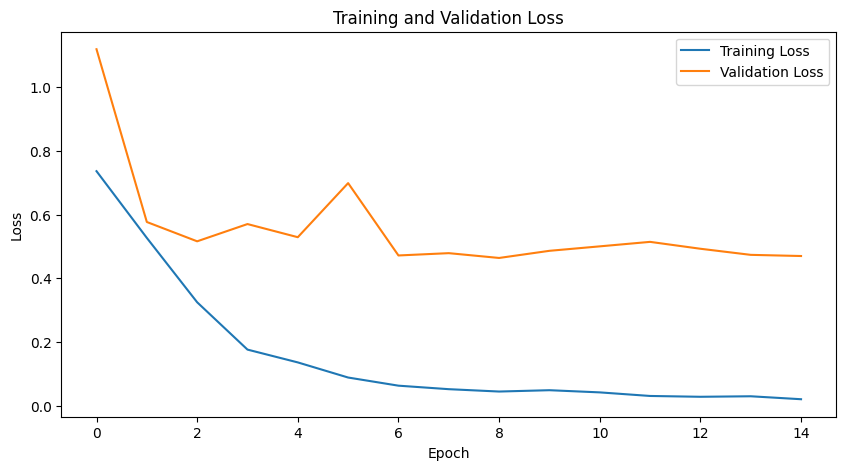

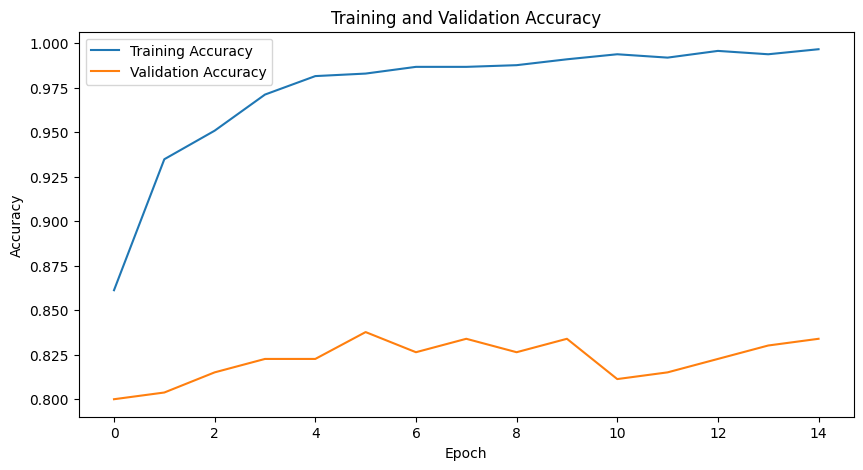

In [7]:
max_loss_threshold = 2.0
min_accuracy_threshold = 0.8

filtered_train_loss = [v for v in history.history['loss'] if v <= max_loss_threshold]
filtered_val_loss = [v for v in history.history['val_loss'] if v <= max_loss_threshold]

filtered_train_accuracy = [v for v in history.history['accuracy'] if v >= min_accuracy_threshold]
filtered_val_accuracy = [v for v in history.history['val_accuracy'] if v >= min_accuracy_threshold]

min_len = min(len(filtered_train_loss), len(filtered_val_loss), len(filtered_train_accuracy), len(filtered_val_accuracy))
filtered_train_loss = filtered_train_loss[:min_len]
filtered_val_loss = filtered_val_loss[:min_len]
filtered_train_accuracy = filtered_train_accuracy[:min_len]
filtered_val_accuracy = filtered_val_accuracy[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(filtered_train_loss, label='Training Loss')
plt.plot(filtered_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(filtered_train_accuracy, label='Training Accuracy')
plt.plot(filtered_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [8]:
model.load_weights('best_model.keras')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.8515 - loss: 0.4576
Test Loss: 0.4852, Test Accuracy: 0.84%
